In [1]:
import matplotlib.pyplot as plt

import time
import pandas as pd
import numpy as np
from numpy import arange, sin, pi, random

from sklearn.metrics import accuracy_score

import scipy.integrate as integrate

from sklearn.metrics import f1_score
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
# np.random.seed(1234)
# PYTHONHASHSEED = 0
from sklearn.metrics import recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, RepeatVector,TimeDistributed
from tensorflow.keras.optimizers import RMSprop,Adam

C:\Users\SanHa\anaconda3\envs\bms\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def gen_wave():
    """ Generate a synthetic data
    :return: the final data
    """
    t = np.arange(0.0, 100.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 20.0, 0.01)
    wave3 = -2*sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.5 * len(t))
    wave1[insert:insert + 2000] = wave1[insert:insert + 2000] + wave3
    return wave1 - 2*wave2

def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def get_split_volts(train_start, train_end,
                          test_start, test_end, x):
    
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#     X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x sequence length x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return (flattened_X)


# Tran et al., 2019

def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(64,
                   input_shape=(18,1),return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(128,
                   return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(256,
                   return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(100,
                   return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1,activation='linear'))

    start = time.time()
    optimizer = Adam(lr=1e-4)
    model.compile(loss="mse", optimizer= optimizer)
    print ("Compilation Time : ", time.time() - start)
    return model

def build_autoencoder(X_train,y_train):
    lstm_autoencoder = Sequential()
    #Encoder
    lstm_autoencoder.add(LSTM(16,activation='relu', input_shape=(18,1), return_sequences=True))
    lstm_autoencoder.add(LSTM(32,activation='relu',return_sequences=False))
    lstm_autoencoder.add(RepeatVector(18))
    #Decoder
    lstm_autoencoder.add(LSTM(64,activation='relu',return_sequences=True))
    lstm_autoencoder.add(LSTM(128,activation='relu',return_sequences=True))
    lstm_autoencoder.add(TimeDistributed(Dense(1)))
    lstm_autoencoder.summary()
    optimizer = Adam(lr=1e-4)
    lstm_autoencoder.compile(loss='mse',optimizer=optimizer)
    cp = ModelCheckpoint(filepath='lstm_autoencoder_classifier.h5',
                         save_best_only=True,
                         verbose=0)
    earlystopping=(EarlyStopping(monitor='val_loss',patience=10))
    callbacks=[cp,earlystopping]
    lstm_autoencoder_history = lstm_autoencoder.fit(X_train,y_train,
                                                   epochs=epochs,
                                                    batch_size=batch_size,
                                                    validation_split=0.05,
                                                    verbose=2,
                                                    callbacks=callbacks)
    return lstm_autoencoder,lstm_autoencoder_history
# KDE
def kde_sklearn(x, bandwidth=0.2, **kwargs):
    x_grid = np.linspace(x.min() - 0.9 * x.min(), x.max() + x.max(), 500)
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf), x_grid


def FindThreshold(x, h, p):
    tau = 0
    x.sort()
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1 / (h * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (s - p) / h), (i - 1) / len(x),
                               i / len(x))
        tau = tau + int_K[0] * x[i]
    return tau

In [3]:
def gen_volts():
    sample=pd.read_csv("./PorterFTP(40).csv")
    x_volts=sample['셀전압']
    x_watts = x_volts ** 2
    x=[]
    for i in range(20):
        # Set a target SNR
        target_snr_db = 25
        # Calculate signal power and convert to dB 
        sig_avg_watts = np.mean(x_watts)
        sig_avg_db = np.log10(sig_avg_watts)
        # Calculate noise according to [2] then convert to watts
        noise_avg_db = sig_avg_db - target_snr_db
        noise_avg_watts = 20 ** (noise_avg_db / 10)
        # Generate an sample of white noise
        mean_noise = 0
        noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
        # Noise up the original signal
        globals()['y_volts_{}'.format(i)] = x_volts + noise_volts
        x.append('y_volts_{0}'.format(i))
    np.array(y_volts_13)
    y_volts_13[1500:]=y_volts_13[1500:]+0.07
    return x,y_volts_13

In [4]:

train_data,test_data=gen_volts()
del train_data[13]

In [5]:
for i in range(len(train_data)):
    train_data=pd.concat([y_volts_0,y_volts_1,y_volts_2,y_volts_3,y_volts_4,y_volts_5,y_volts_6,y_volts_7,y_volts_8,y_volts_9,y_volts_10,y_volts_11,y_volts_12,y_volts_14,y_volts_15,y_volts_16,y_volts_17,y_volts_18,y_volts_19],axis=1)

In [6]:
train_data=np.array(train_data)

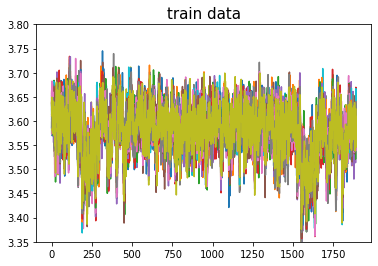

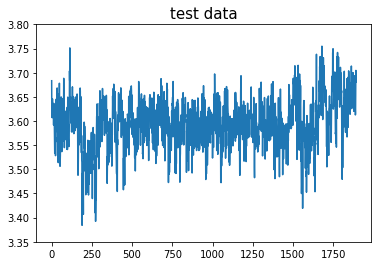

In [7]:
plt.ylim([3.35,3.8])
plt.title("train data",fontsize=15)
for i in range(len(train_data[1])):
    plt.plot(train_data[:,i])
    
plt.figure()
plt.ylim([3.35,3.8])
plt.title("test data",fontsize=15)
plt.plot(test_data)

In [8]:
train_data.shape

(1893, 19)

In [9]:
result=train_data  # shape (samples, sequence_length)
X_scaler=MinMaxScaler()

y_train = result[:, -1]
y_scaler = MinMaxScaler()
# y_train = y_scaler.fit_transform(y_train)
y_train[0]

3.6365830387367706

In [10]:
#train data split
print("Length of Data", len(train_data))
# train data
print ("Creating train data...")
result=train_data  # shape (samples, sequence_length)
result, result_mean = z_norm(result)
print(result.shape)
print ("Mean of train data : ", result_mean)
print ("Train data shape  : ", result.shape)
X_train = result[:, :-1]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = result[:, -1]


Length of Data 1893
Creating train data...
(1893, 19)
Mean of train data :  3.5790304915570155
Train data shape  :  (1893, 19)


In [11]:
y_train.shape

(1893,)

In [12]:
print(X_train.shape)
print(y_train.shape)

(1893, 18, 1)
(1893,)


In [13]:
print(test_data.shape)

(1893,)


In [14]:
data = test_data
sequence_length=19
# test data
print ("Creating test data...")

result = []
for index in range(sequence_length):
    result.append(data)

result = np.array(result)  # shape (samples, sequence_length)
result = np.transpose(result)

result, result_mean = z_norm(result)

print ("Mean of test data : ", result_mean)
print ("Test data shape  : ", result.shape)

X_test = result[:, :-1]
y_test = result[:, -1]
print("Shape X_test", np.shape(X_test))


X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


Creating test data...
Mean of test data :  3.593141220374545
Test data shape  :  (1893, 19)
Shape X_test (1893, 18)


In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1893, 18, 1)
(1893,)
(1893, 18, 1)
(1893,)


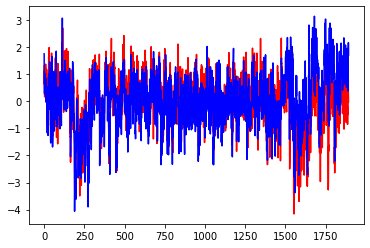

In [16]:
plt.plot(flatten(X_train),c='r')
plt.plot(flatten(X_test),c='b')

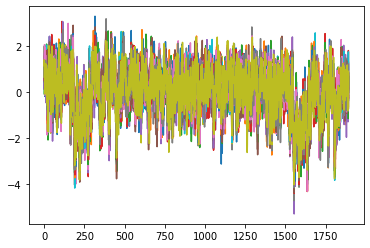

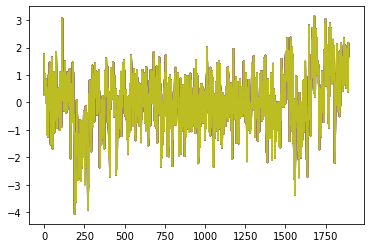

In [17]:

for i in range(len(X_train[1])):
    plt.plot(X_train[:,i])
plt.plot(y_train)
plt.figure()
for i in range(len(X_test[1])):
    plt.plot(X_test[:,i])
plt.plot(y_test)

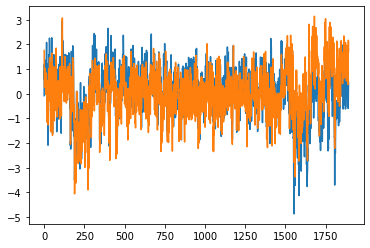

In [18]:
plt.plot(X_train[:,2])
plt.plot(X_test[:,0])

In [19]:
y_train.shape

(1893,)

(1893, 18, 1)
(1893, 18, 1)
(1893,)
(1893,)


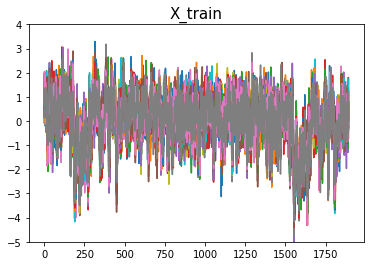

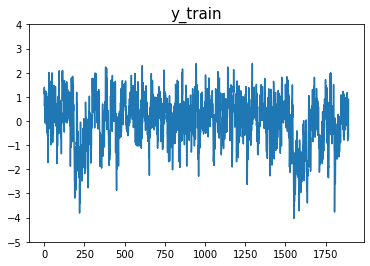

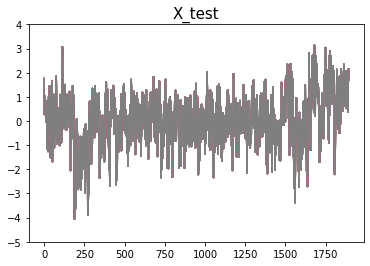

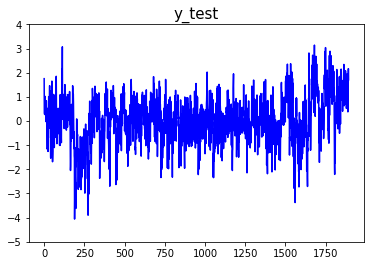

<Figure size 432x288 with 0 Axes>

In [20]:
plt.title("X_train",fontsize=15)
plt.ylim([-5,4])
for i in range(len(X_train[1])):
    plt.plot(X_train[:,i])
plt.figure()

plt.title("y_train",fontsize=15)
plt.ylim([-5,4])
plt.plot(y_train)
plt.figure()

plt.title("X_test",fontsize=15)
plt.ylim([-5,4])
for i in range(len(X_test[1])):
    plt.plot(X_test[:,i])
plt.figure()

plt.title("y_test",fontsize=15)
plt.ylim([-5,4])
plt.plot(y_test,c='b')
plt.figure()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [21]:
# batch_size=100
# epochs=50
batch_size=80
epochs=1000

In [22]:
# # train on first 7000 samples and test on next 3000 samples (has anomaly)
# DATA_SPLIT_PCT = 0.2
# SEED = 123 #used to help randomly select the data points
# batch_size = 100

# model=None
# data=None
# global_start_time = time.time()


# print ('Loading data... ')
# # train on first 700 samples and test on next 300 samples (has anomaly)
# print ('\nData Loaded. Compiling...\n')

# model = build_model()
# model.summary()

(1893, 18, 1)
(1893,)
(1893, 18, 1)
(1893,)


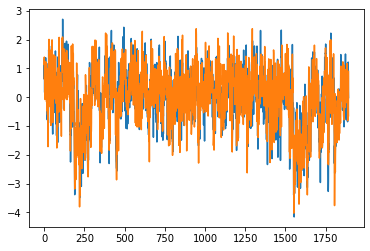

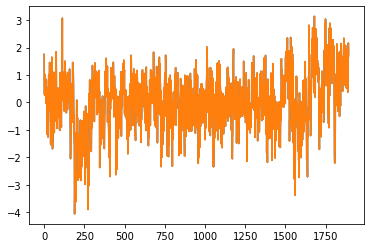

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_train.shape)
plt.plot(flatten(X_train))
plt.plot(y_train)
plt.figure()
plt.plot(flatten(X_test))
plt.plot(y_test)

In [24]:



# # X_train_X, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, random_state=SEED)
# # timesteps =  X_train.shape[1] # equal to the sequence_length
# # n_features =  X_train.shape[2] # 1
# path_checkpoint = r'C:\Users\SanHa\Desktop\log\anomaly detection\\forecasting\cp.ckpt'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=False)
# callback_early_stopping = EarlyStopping(monitor='val_loss',
#                                         patience=5, verbose=1)
# callback_reduce_lr= ReduceLROnPlateau(monitor='val_loss',
#                                      factor=0.1,
#                                      min_lr=1e-5,
#                                      patience=3,
#                                      verbose=1)

# callbacks = [callback_early_stopping,
#             callback_checkpoint,
# #             callback_tensorboard]
#             callback_reduce_lr]

In [25]:
lstm_autoencoder,lstm_autoencoder_history=build_autoencoder(X_train,y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 18, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 18, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 18, 64)            24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 18, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 18, 1)             129       
Total params: 131,201
Trainable params: 131,201
Non-trainable params: 0
__________________________________________________

Epoch 109/1000
23/23 - 2s - loss: 0.3462 - val_loss: 0.3103
Epoch 110/1000
23/23 - 2s - loss: 0.3476 - val_loss: 0.3044
Epoch 111/1000
23/23 - 2s - loss: 0.3478 - val_loss: 0.3126
Epoch 112/1000
23/23 - 2s - loss: 0.3467 - val_loss: 0.3030
Epoch 113/1000
23/23 - 2s - loss: 0.3455 - val_loss: 0.3008
Epoch 114/1000
23/23 - 2s - loss: 0.3465 - val_loss: 0.3005
Epoch 115/1000
23/23 - 2s - loss: 0.3450 - val_loss: 0.3126
Epoch 116/1000
23/23 - 2s - loss: 0.3490 - val_loss: 0.3051
Epoch 117/1000
23/23 - 2s - loss: 0.3469 - val_loss: 0.3012
Epoch 118/1000
23/23 - 2s - loss: 0.3448 - val_loss: 0.3112
Epoch 119/1000
23/23 - 2s - loss: 0.3483 - val_loss: 0.3070
Epoch 120/1000
23/23 - 2s - loss: 0.3463 - val_loss: 0.3047
Epoch 121/1000
23/23 - 2s - loss: 0.3453 - val_loss: 0.3076
Epoch 122/1000
23/23 - 2s - loss: 0.3445 - val_loss: 0.3008
Epoch 123/1000
23/23 - 2s - loss: 0.3466 - val_loss: 0.3014
Epoch 124/1000
23/23 - 2s - loss: 0.3449 - val_loss: 0.3038


In [26]:
lstm_autoencoder_history.history

{'loss': [1.0297253131866455,
  1.0092188119888306,
  0.9663237929344177,
  0.8556532263755798,
  0.9614940881729126,
  0.7165981531143188,
  0.681163489818573,
  0.6586245894432068,
  0.6394755244255066,
  0.6226394772529602,
  0.6055701375007629,
  0.5899004340171814,
  0.5781600475311279,
  0.5677334070205688,
  0.5563356280326843,
  0.5473871231079102,
  0.5377745032310486,
  0.53102046251297,
  0.5214404463768005,
  0.5149100422859192,
  0.5068674683570862,
  0.49931055307388306,
  0.4908115565776825,
  0.4819709062576294,
  0.4756031334400177,
  0.46886515617370605,
  0.4627670347690582,
  0.4581018090248108,
  0.45254287123680115,
  0.44730454683303833,
  0.44321510195732117,
  0.439198762178421,
  0.43654710054397583,
  0.4316447079181671,
  0.4284777045249939,
  0.42613956332206726,
  0.42281025648117065,
  0.41967448592185974,
  0.4176173806190491,
  0.41555532813072205,
  0.4155067801475525,
  0.4116997718811035,
  0.4097054600715637,
  0.4062291085720062,
  0.40377736091613

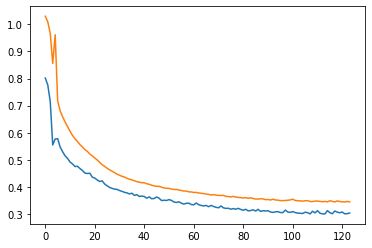

In [27]:
validation_loss=lstm_autoencoder_history.history['val_loss']
train_loss = lstm_autoencoder_history.history['loss']
plt.plot(validation_loss)
plt.plot(train_loss)

In [28]:
predicted_train = lstm_autoencoder.predict(X_train)
predicted = lstm_autoencoder.predict(X_test)

In [29]:
print(predicted.shape)
print(X_test.shape)

(1893, 18, 1)
(1893, 18, 1)


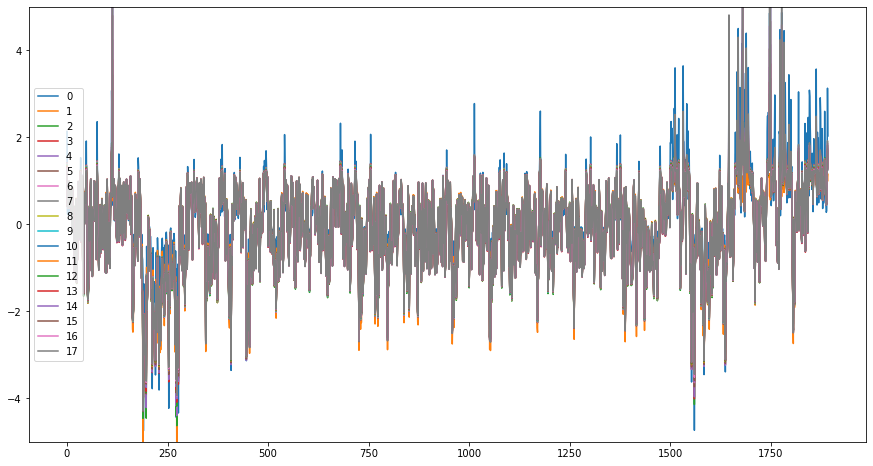

In [30]:
plt.figure(figsize=(15,8))
plt.ylim([-5,5])
for i in range(len(predicted[1])):
    plt.plot(predicted[:,i],label='{}'.format(i))
plt.legend(loc='center left')

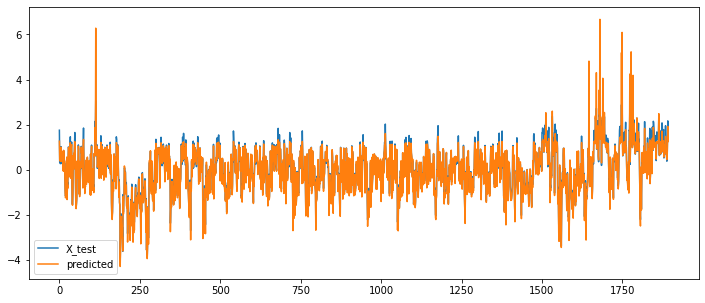

In [31]:
plt.figure(figsize=(12,5))
# plt.ylim([-5,5])
plt.plot(flatten(X_test),label='X_test')
plt.plot(flatten(predicted),label='predicted')
plt.legend()

In [32]:
print((flatten(X_test) - flatten(predicted)).shape)
print(flatten(X_test).shape)

(1893, 1)
(1893, 1)


In [33]:
import seaborn as sns

C:\Users\SanHa\anaconda3\envs\bms\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.05555555555555555
tau: 4.2895074828849316


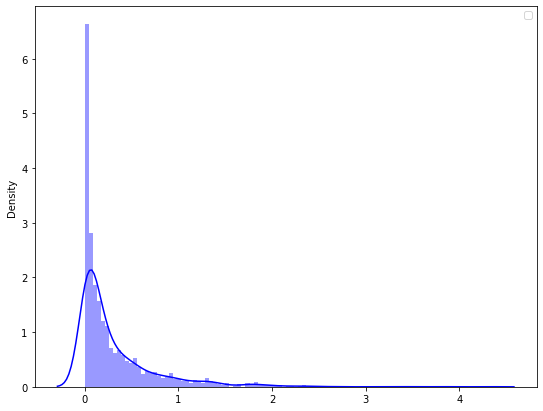

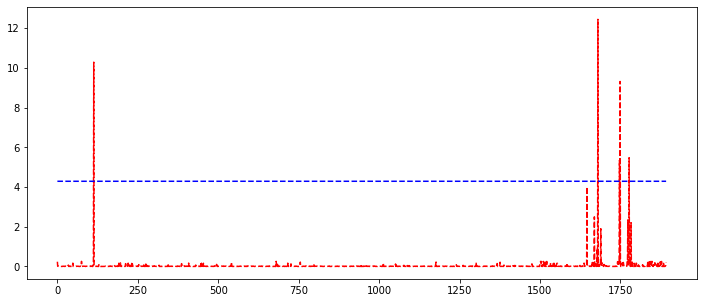

In [34]:
fig, ax2 = plt.subplots(figsize = (9,7))

mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)
mse_train = np.mean(np.power(flatten(X_train) - flatten(predicted_train), 2), axis=1)
#KDE
plt.legend(["Anomaly scores[MSE]"])

sns.distplot(mse_train, bins = 100, kde= True, color = 'blue');
# ax2.hist(mse_train, bins = 100, alpha = 0.5, density = True)
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.linspace(0, 0.5, 10)}
grid = GridSearchCV(KernelDensity(), params, cv = 20)
grid.fit(mse_train[:, None])
h=grid.best_estimator_.bandwidth
# tau=FindThreshold(mse_train,h,0.56)
tau=max(mse_train)
y_test1=np.ones(X_test.shape[0])
y_test1[999:1499]=-1
y_scores=np.ones(X_test.shape[0])
y_scores[(mse-tau)>0]=-1
# accuracy_kde = accuracy_score(y_test1, y_scores)
plt.figure(figsize=(12,5))
# plt.ylim([0,10])lll
# red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
# red_dot=plt.plot(mse, 'r--')
print(h)
print("tau:",tau)

In [35]:
predicted.shape

(1893, 18, 1)

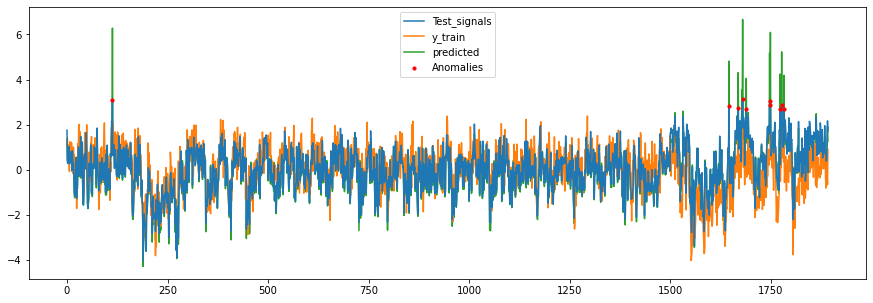

In [36]:
index=[]
for i in range(len(mse)):
    if mse[i,]>1.5:
        index.append(i)
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0,0],zorder=3)
plt.plot(y_train,zorder=2)
plt.plot(flatten(predicted),zorder=1)
plt.scatter(index,X_test[index,0,0],color='r',zorder=4,s=10)
plt.legend(['Test_signals','y_train','predicted','Anomalies'])

In [37]:
len(index)

10

In [38]:
minval=0
index=0
for i in range(1500,1600):
    if X_test[i,0,0]<minval:
        minval = X_test[i,0,0]
        index=i
print(minval)
print(i)

-3.3756478625461375
1599


In [39]:

# model.fit(X_train,y_train,
#          batch_size = batch_size,
#           epochs=50,
#           validation_split=0.1)

In [40]:
print("Predicting...")
predicted_train = model.predict(X_train)
print(X_test.shape)
predicted = model.predict(X_test)
print(predicted.shape)
print("Reshaping predicted")
predicted_train = np.reshape(predicted_train, (predicted_train.size,))
predicted = np.reshape(predicted, (predicted.size,))



# #Plot histogram
# fig, ax2 = plt.subplots(figsize = (9,7))
# ax2.hist(mse_train, bins = 100, alpha = 0.5, density = True)
# # mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)


Predicting...


NameError: name 'model' is not defined

In [ ]:
print(predicted_train.shape)
print(predicted.shape)
# plt.plot(predicted_train)
plt.plot(predicted,label='predicted',zorder=1)
plt.plot(flatten(X_test), label='X_test',zorder=0)
plt.legend()
# plt.figure()
# plt.title("predicted_train")
# plt.plot(flatten(predicted_train))
# plt.figure()
# plt.title("predicted_test")
# plt.plot(flatten(predicted))
# plt.figure()
# plt.title("X_test")
# plt.plot(flatten(X_test))

In [ ]:
# mse = ((y_test - predicted) ** 2)
# plt.legend(["Anomaly scores[MSE]"])
# mse_train = ((y_train - predicted_train) ** 2)
# # use grid search cross-validation to optimize the bandwidth
# params = {'bandwidth': np.linspace(0, 0.5, 10)}
# grid = GridSearchCV(KernelDensity(), params, cv = 20)
# grid.fit(mse_train[:, None])
# print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
# h=grid.best_estimator_.bandwidth
# tau=FindThreshold(mse_train,h,0.56)
# #tau=max(mse_train)
# y_test1=np.ones(len(y_test))
# y_test1[999:1499]=-1
# y_scores=np.ones(len(y_test))
# y_scores[(mse-tau)>0]=-1

# precision = precision_score(y_test1, y_scores)
# recall    = recall_score(y_test1, y_scores)
# accuracy = accuracy_score(y_test1, y_scores)
# f1 = f1_score(y_test1, y_scores, average='macro') 

# fig=plt.figure(3)
# red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
# # red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*0.275, 'b--')
# plt.xlabel('t')
# plt.ylabel('Anomaly scores')
# plt.legend([red_dot, (red_dot, white_cross)], ["Restore loss", "Threshold"])
# plt.show()
# # fig.savefig('plot.png', dpi=1200)
# print ('Tau : ', tau)
# print ('Precision : ', precision)
# print ('Recall: ', recall)
# print ('Accuracy : ', accuracy)
# print ('F1_score: ', f1)

In [ ]:
print("predicting")

#Plot histogram
fig, ax2 = plt.subplots(figsize = (9,7))

# mse = np.mean(np.power(flatten(X_test) - flatten(predicted), 2), axis=1)

mse = ((y_test - predicted) ** 2)
mse_train = ((y_train - predicted_train) ** 2)
plt.legend(["Anomaly scores[MSE]"])
ax2.hist(mse_train, bins = 100, alpha = 0.5, density = True)
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.linspace(0, 0.5, 10)}
grid = GridSearchCV(KernelDensity(), params, cv = 20)
grid.fit(mse_train[:, None])
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
h=grid.best_estimator_.bandwidth
tau=FindThreshold(mse_train,h,0.56)
#tau=max(mse_train)
y_test1=np.ones(len(y_test))
y_test1[999:1499]=-1
y_scores=np.ones(len(y_test))
y_scores[(mse-tau)>0]=-1

precision = precision_score(y_test1, y_scores)
recall    = recall_score(y_test1, y_scores)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, average='macro') 

fig=plt.figure(3)
red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*tau, 'b--')
# red_dot, white_cross =plt.plot(mse, 'r--', np.ones(len(mse))*0.275, 'b--')
plt.xlabel('t')
plt.ylabel('Anomaly scores')
plt.legend([red_dot, (red_dot, white_cross)], ["Restore loss", "Threshold"])
plt.show()
fig.savefig('plot.png', dpi=1200)
print ('Tau : ', tau)
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('Accuracy : ', accuracy)
print ('F1_score: ', f1)

In [ ]:
mse

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(predicted,c='r',zorder=1)
plt.plot(X_test[:,0,0],'b',zorder=0)
plt.legend(["Decoder Pred", "True data"])

In [ ]:
index=[]
tau=0.14
for i in range(len(mse)):
    if mse[i,]>tau:
        index.append(i)
# plt.figure(figsize=(20,5))
plt.plot(X_test[:,0,0],zorder=1)
plt.scatter(index,X_test[index,0,0],color='r',zorder=2,s=10)
plt.legend(['Signals','Anomalies'])

In [ ]:
plt.plot(flatten(X_train))
plt.plot(y_train)
plt.figure()
plt.plot(flatten(X_test),c='r')
plt.plot(y_test,c='b')
plt.plot(predicted,c='g')